# E-commerce Data EDA

Ce notebook charge le dataset Kaggle "Ecommerce Data" via KaggleHub, et mène une EDA : qualité des données, exploration business (chiffre d'affaires, clients, produits), et visualisations interactives.

In [49]:
# Data acquisition via KaggleHub (cached)
import kagglehub
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

path = kagglehub.dataset_download("carrie1/ecommerce-data")
csv_path = Path(path) / "data.csv"


# Read with appropriate encoding
raw = pd.read_csv(csv_path, encoding="ISO-8859-1")
print(raw.shape)
raw.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [50]:
# Rename columns to snake_case
def to_snake(name: str) -> str:
    name = re.sub(r'[^0-9a-zA-Z]+', '_', name)                # replace non-alphanum by _
    name = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)        # case CamelCase
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name)       # case transitions aZ
    return name.strip('_').lower()

raw.columns = [to_snake(c) for c in raw.columns]

# Parse dates
if 'invoice_date' in raw.columns:
    raw['invoice_date'] = pd.to_datetime(raw['invoice_date'], errors='coerce')

# Drop obviously invalid rows (negative or zero quantities/prices often indicate corrections/credits)
clean = raw.copy()
clean = clean.dropna(subset=['invoice_no', 'stock_code'])
if 'quantity' in clean.columns:
    clean = clean[clean['quantity'] > 0]
if 'unit_price' in clean.columns:
    clean = clean[clean['unit_price'] > 0]

# Clean description field for whitespace
if 'description' in clean.columns:
    clean['description'] = clean['description'].astype(str).str.strip()

# Add income feature
if set(['quantity', 'unit_price']).issubset(clean.columns):
    clean['income'] = clean['quantity'] * clean['unit_price']


In [51]:
n0 = len(raw)
n1 = len(clean)
print(f"Rows before: {n0:,} | after basic clean: {n1:,} | removed: {n0-n1:,} ({(n0-n1)/n0:.1%})")

Rows before: 541,909 | after basic clean: 530,104 | removed: 11,805 (2.2%)


In [52]:
# Replace missing values in 'customer_id' with a placeholder (e.g., -1) if 'customer_id' in clean.columns:
if 'customer_id' in clean.columns:
    clean['customer_id'] = clean['customer_id'].fillna("UNKNOWN").astype(str)

if 'customer_id' in clean.columns:
    unique_customers = clean['customer_id'].nunique()
    print(f"Unique customers: {unique_customers}")

unknown_customers = clean[clean['customer_id'] == "UNKNOWN"]
print(f"Entries with unknown customer ID: {len(unknown_customers)}")


Unique customers: 4339
Entries with unknown customer ID: 132220


In [53]:
# Key for identifying duplicates (should uniquely identify a transaction)  

key = ['invoice_no', 'stock_code', 'invoice_date', 'customer_id']

if set(key).issubset(clean.columns):
    dup_mask = clean.duplicated(subset=key, keep='first')
    n_dups = int(dup_mask.sum())
    print(f"Number of duplicates for {key}: {n_dups}")

    display(clean[dup_mask].head())

    clean = clean.drop_duplicates(subset=key, keep='first')
    print(f"After deduplication: {len(clean):,} rows")

Number of duplicates for ['invoice_no', 'stock_code', 'invoice_date', 'customer_id']: 10495


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,income
125,536381,71270,PHOTO CLIP LINE,3,2010-12-01 09:41:00,1.25,15311.0,United Kingdom,3.75
498,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,1,2010-12-01 11:45:00,6.35,17908.0,United Kingdom,6.35
502,536409,85116,BLACK CANDELABRA T-LIGHT HOLDER,5,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,10.50
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
525,536409,90199C,5 STRAND GLASS NECKLACE CRYSTAL,2,2010-12-01 11:45:00,6.35,17908.0,United Kingdom,12.70


After deduplication: 519,609 rows


Min (brut):
 quantity      1.000
unit_price    0.001
income        0.001
dtype: float64
Max (brut):
 quantity       80995.00
unit_price     13541.33
income        168469.60
dtype: float64


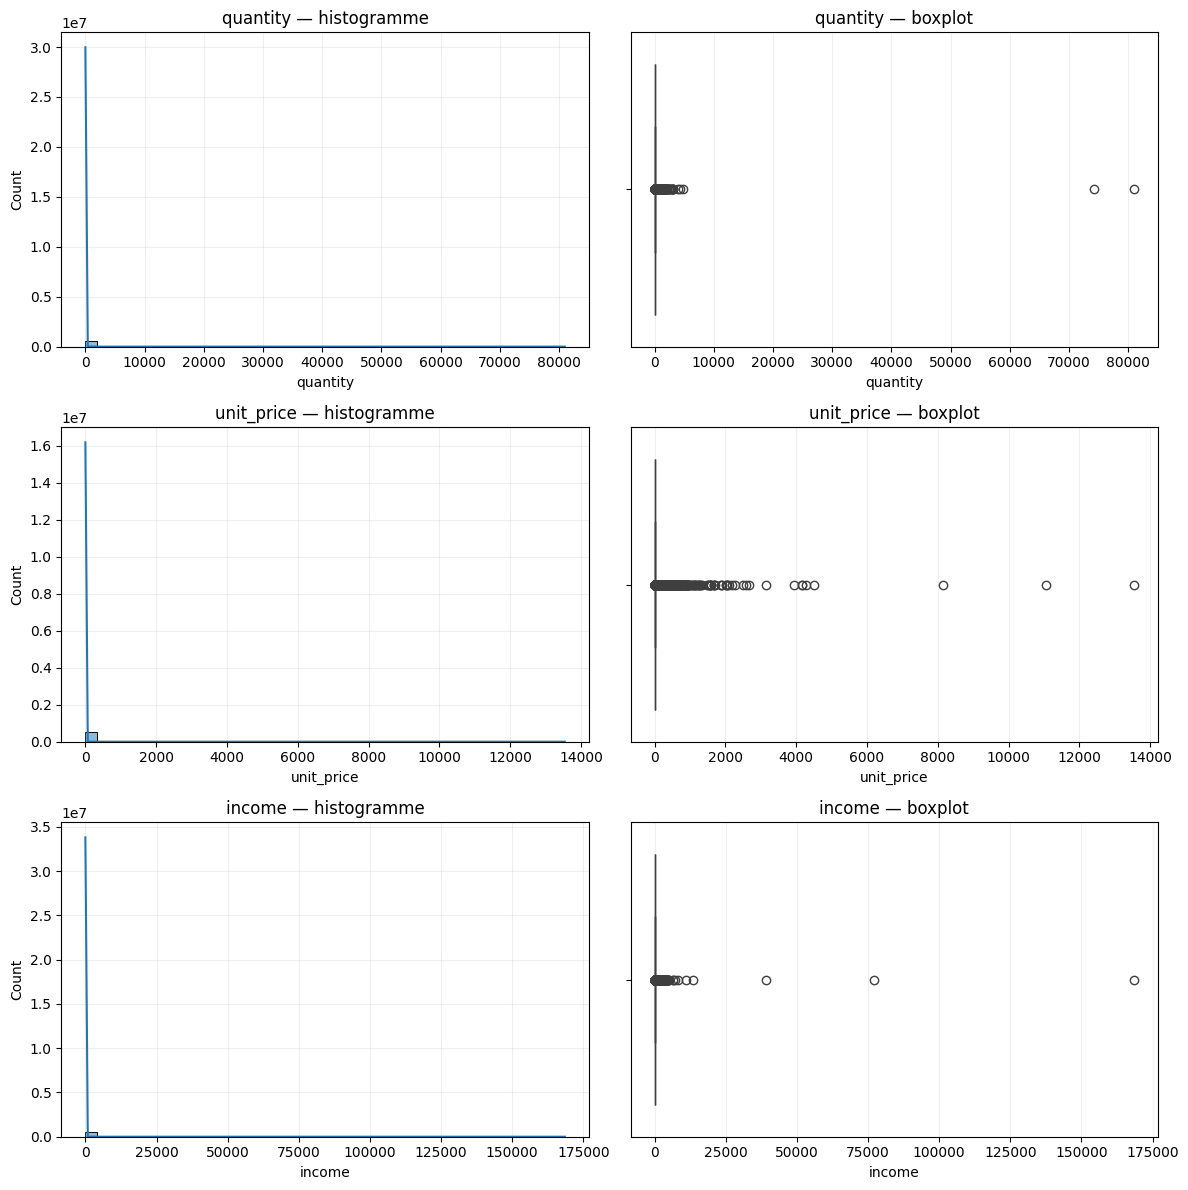

,count,mean,std,min,25%,50%,75%,max
quantity,519609.0,10.675652,157.060991,1.000,1.00,4.00,12.00,80995.00
unit_price,519609.0,3.922728,35.905976,0.001,1.25,2.10,4.13,13541.33
income,519609.0,20.384061,273.007846,0.001,3.95,9.95,17.70,168469.60


In [54]:
# Distribution de quantity, unit_price et income

cols = [c for c in ['quantity', 'unit_price', 'income'] if c in clean.columns]

if cols:
    # Min/Max bruts pour repérer les valeurs extrêmes
    mins = clean[cols].min(numeric_only=True)
    maxs = clean[cols].max(numeric_only=True)
    print("Min (brut):\n", mins)
    print("Max (brut):\n", maxs)

    n = len(cols)
    fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))
    if n == 1:
        axes = np.array([axes])  # garantir une forme (n,2)

    for i, col in enumerate(cols):
        s = clean[col].dropna()

        # 1) Histogramme + KDE (données brutes)
        sns.histplot(s, bins=40, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f"{col} — histogramme")
        axes[i, 0].grid(True, alpha=0.2)

        # 2) Boxplot (données brutes)
        sns.boxplot(x=s, ax=axes[i, 1])
        axes[i, 1].set_title(f"{col} — boxplot")
        axes[i, 1].grid(True, axis='x', alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Statistiques descriptives complètes (données brutes)
    display(clean[cols].describe(include='all').T)

Il y a énormément de valeurs extrêmes, la vue log10 devrait rendre la forme générale plus lisible.

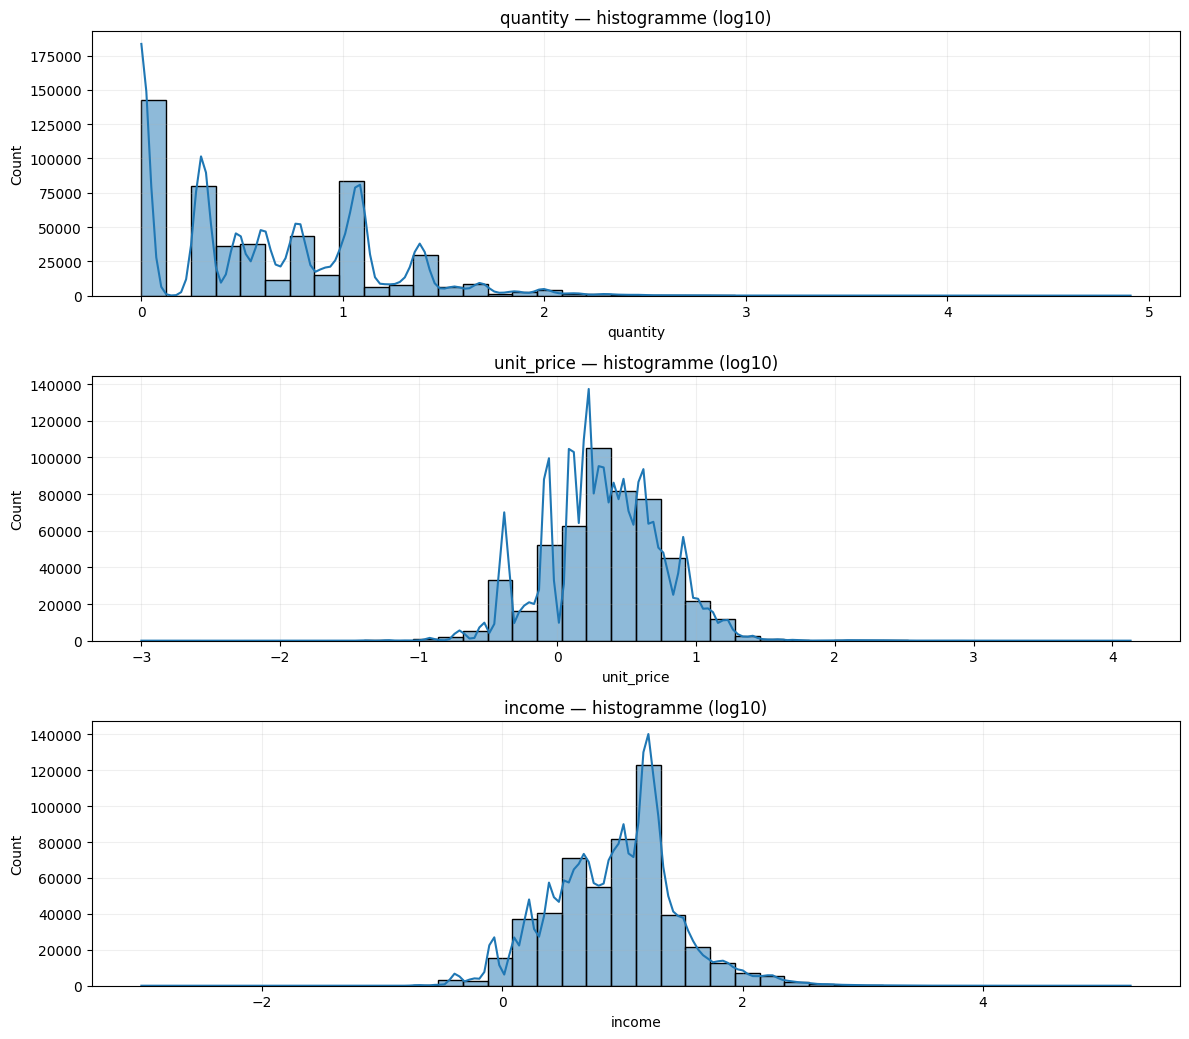

In [55]:
# Étape 2 — Histogrammes log10 par variable (si > 0)
cols = [c for c in ['quantity', 'unit_price', 'income'] if c in clean.columns]
if cols:
    n = len(cols)
    fig, axes = plt.subplots(n, 1, figsize=(12, 3.5*n))
    if n == 1:
        axes = np.array([axes])
    for i, col in enumerate(cols):
        s = clean[col].dropna()
        positive = s[s > 0]
        if len(positive) > 0:
            sns.histplot(np.log10(positive), bins=40, kde=True, ax=axes[i])
            axes[i].set_title(f"{col} — histogramme (log10)")
            axes[i].grid(True, alpha=0.2)
        else:
            axes[i].text(0.5, 0.5, f"{col}: pas de valeurs > 0", ha='center', va='center')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [56]:
# Top 10 valeurs extrêmes pour inspection (quantity, unit_price, income)
cols = [c for c in ['quantity', 'unit_price', 'income'] if c in clean.columns]
id_cols = [c for c in ['invoice_no', 'invoice_date', 'stock_code', 'customer_id', 'description'] if c in clean.columns]

def top_n(df, col, n=10):
    return (
        df[df[col].notna()]
          .sort_values(col, ascending=False)
          .head(n)
          [[col] + id_cols]
    )

if cols:
    for col in cols:
        print(f"\nTop 10 plus grandes valeurs pour: {col}")
        display(top_n(clean, col))


Top 10 plus grandes valeurs pour: quantity


,quantity,invoice_no,invoice_date,stock_code,customer_id,description
540421,80995,581483,2011-12-09 09:15:00,23843,16446.0,"PAPER CRAFT , LITTLE BIRDIE"
61619,74215,541431,2011-01-18 10:01:00,23166,12346.0,MEDIUM CERAMIC TOP STORAGE JAR
421632,4800,573008,2011-10-27 12:26:00,84077,12901.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS
206121,4300,554868,2011-05-27 10:52:00,22197,13135.0,SMALL POPCORN HOLDER
97432,3906,544612,2011-02-22 10:43:00,22053,18087.0,EMPIRE DESIGN ROSETTE
270885,3186,560599,2011-07-19 17:04:00,18007,14609.0,ESSENTIAL BALM 3.5g TIN IN ENVELOPE
52711,3114,540815,2011-01-11 12:55:00,21108,15749.0,FAIRY CAKE FLANNEL ASSORTED COLOUR
160546,3114,550461,2011-04-18 13:20:00,21108,15749.0,FAIRY CAKE FLANNEL ASSORTED COLOUR
433788,3000,573995,2011-11-02 11:24:00,16014,16308.0,SMALL CHINESE STYLE SCISSOR
4945,2880,536830,2010-12-02 17:38:00,84077,16754.0,WORLD WAR 2 GLIDERS ASSTD DESIGNS



Top 10 plus grandes valeurs pour: unit_price


,unit_price,invoice_no,invoice_date,stock_code,customer_id,description
15017,13541.33,537632,2010-12-07 15:08:00,AMAZONFEE,UNKNOWN,AMAZON FEE
299982,11062.06,A563185,2011-08-12 14:50:00,B,UNKNOWN,Adjust bad debt
173382,8142.75,551697,2011-05-03 13:46:00,POST,16029.0,POSTAGE
297723,4505.17,562955,2011-08-11 10:14:00,DOT,UNKNOWN,DOTCOM POSTAGE
268028,4287.63,560373,2011-07-18 12:30:00,M,UNKNOWN,Manual
422376,4161.06,573080,2011-10-27 14:20:00,M,12536.0,Manual
422351,4161.06,573077,2011-10-27 14:13:00,M,12536.0,Manual
406406,3949.32,571751,2011-10-19 11:18:00,M,12744.0,Manual
374542,3155.95,569382,2011-10-03 16:44:00,M,15502.0,Manual
347948,2653.95,567353,2011-09-19 16:14:00,M,UNKNOWN,Manual



Top 10 plus grandes valeurs pour: income


,income,invoice_no,invoice_date,stock_code,customer_id,description
540421,168469.60,581483,2011-12-09 09:15:00,23843,16446.0,"PAPER CRAFT , LITTLE BIRDIE"
61619,77183.60,541431,2011-01-18 10:01:00,23166,12346.0,MEDIUM CERAMIC TOP STORAGE JAR
222680,38970.00,556444,2011-06-10 15:28:00,22502,15098.0,PICNIC BASKET WICKER 60 PIECES
15017,13541.33,537632,2010-12-07 15:08:00,AMAZONFEE,UNKNOWN,AMAZON FEE
299982,11062.06,A563185,2011-08-12 14:50:00,B,UNKNOWN,Adjust bad debt
173382,8142.75,551697,2011-05-03 13:46:00,POST,16029.0,POSTAGE
348325,7144.72,567423,2011-09-20 11:05:00,23243,17450.0,SET OF TEA COFFEE SUGAR TINS PANTRY
52711,6539.40,540815,2011-01-11 12:55:00,21108,15749.0,FAIRY CAKE FLANNEL ASSORTED COLOUR
160546,6539.40,550461,2011-04-18 13:20:00,21108,15749.0,FAIRY CAKE FLANNEL ASSORTED COLOUR
421601,4992.00,573003,2011-10-27 12:11:00,23084,14646.0,RABBIT NIGHT LIGHT


C’est problématique. Les lignes sans `customer_id` présentent souvent des valeurs extrêmes sur les prix et les quantités. Comme on souhaite potentiellement créer des features basées sur l’historique des prix et des volumes vendus, ces cas perturbent fortement l’analyse. Première recommandation : définir une stratégie explicite pour les transactions “anormales” ou “spéciales”.

Question de fond: pourquoi une transaction peut-elle exister sans `customer_id` ? Si l’achat “invité” est autorisé, il serait plus propre d’attribuer un identifiant dédié (par exemple GUEST) plutôt que de laisser la valeur manquante. En attendant côté data, on peut utiliser un marqueur comme "UNKNOWN" pour rester cohérents.
